In [ ]:
from google.colab import drive
drive.mount("/content/drive")
#! ls "/content/drive/My Drive"


Mounted at /content/drive


In [ ]:
import os 
os.getcwd()

'/content'

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/AI比赛/反欺诈预测/') 

In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks/AI比赛/反欺诈预测


In [ ]:
#Baseline4:不参与建模的特征 sid , os 构建新的特征osv1(label1的量/label0的量), area, dev_percent(dev_ppi/area*10000)，android_id_len
#调参数，网格搜索
       
#score:89.0233(newxgb), 88.566(newxgb+ newlgb_5折)

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#加载数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test1.csv')

In [ ]:
train = train.iloc[:,1:]
test = test.iloc[:,1:]
train

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,os,osv,package,sid,timestamp,version,fea_hash,location,fea1_hash,cus_type
0,316361,1199,46000.0,0.0,0.0,0.0,1,NaN,104,6.0,android,9,18,1438873,1.559893e+12,8,2135019403,0,2329670524,601
1,135939,893,0.0,0.0,0.0,0.0,1,NaN,19,6.0,android,8.1,0,1185582,1.559994e+12,4,2782306428,1,2864801071,1000
2,399254,821,0.0,760.0,0.0,360.0,1,NaN,559,0.0,android,8.1.0,0,1555716,1.559837e+12,0,1392806005,2,628911675,696
3,68983,1004,46000.0,2214.0,0.0,1080.0,0,NaN,129,2.0,android,8.1.0,0,1093419,1.560042e+12,0,3562553457,3,1283809327,753
4,288999,1076,46000.0,2280.0,0.0,1080.0,1,zh-CN,64,2.0,android,8.0.0,0,1400089,1.559867e+12,5,2364522023,4,1510695983,582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,392477,1028,46000.0,1920.0,3.0,1080.0,1,zh-CN,144,6.0,Android,7.1.2,25,1546078,1.559834e+12,7,861755946,79,140647032,373
499996,346134,1001,0.0,1424.0,0.0,720.0,0,NaN,29,2.0,android,8.1.0,0,1480612,1.559814e+12,3,1714444511,23,2745131047,525
499997,499635,761,46000.0,1280.0,0.0,720.0,0,NaN,54,6.0,android,6.0.1,9,1698442,1.559676e+12,0,3843262581,25,1326115882,810
499998,239786,917,46001.0,960.0,0.0,540.0,0,zh_CN,109,2.0,android,5.1.1,0,1331155,1.559840e+12,0,1984296118,225,1446741112,772


In [ ]:
#特征概览，查看是否有缺失值，是否不是数字的列，以及唯一值情况
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   android_id  500000 non-null  int64  
 1   apptype     500000 non-null  int64  
 2   carrier     500000 non-null  float64
 3   dev_height  500000 non-null  float64
 4   dev_ppi     500000 non-null  float64
 5   dev_width   500000 non-null  float64
 6   label       500000 non-null  int64  
 7   lan         316720 non-null  object 
 8   media_id    500000 non-null  int64  
 9   ntt         500000 non-null  float64
 10  os          500000 non-null  object 
 11  osv         493439 non-null  object 
 12  package     500000 non-null  int64  
 13  sid         500000 non-null  int64  
 14  timestamp   500000 non-null  float64
 15  version     500000 non-null  object 
 16  fea_hash    500000 non-null  object 
 17  location    500000 non-null  int64  
 18  fea1_hash   500000 non-null  int64  
 19  cu

In [ ]:
#Object类型： lan, os, osv, version, fea_hash
#有缺失值的字段： lan, osv

In [ ]:
features_name = train.columns.tolist()
features_name.remove('label')
features_name

['android_id',
 'apptype',
 'carrier',
 'dev_height',
 'dev_ppi',
 'dev_width',
 'lan',
 'media_id',
 'ntt',
 'os',
 'osv',
 'package',
 'sid',
 'timestamp',
 'version',
 'fea_hash',
 'location',
 'fea1_hash',
 'cus_type']

In [ ]:
for feature_name in features_name:
    print(feature_name, train[feature_name].nunique())

android_id 362258
apptype 89
carrier 5
dev_height 798
dev_ppi 92
dev_width 346
lan 21
media_id 284
ntt 8
os 2
osv 154
package 1950
sid 500000
timestamp 500000
version 22
fea_hash 402980
location 332
fea1_hash 4959
cus_type 58


In [ ]:
train['android_id'].map(lambda x: len(str(x))).value_counts()
#android_id可进行长度处理

6    318713
1    126688
5     48654
4      5438
3       460
2        47
Name: android_id, dtype: int64

In [ ]:
train['fea1_hash'].map(lambda x: len(str(x))).value_counts()

10    391669
9      99347
8       8977
7          6
5          1
Name: fea1_hash, dtype: int64

In [ ]:
train['osv'].value_counts()

8.1.0     151419
9          71332
6.0.1      31714
7.1.1      26503
9.0.0      24385
           ...  
10.3.3         1
9.1            1
5.3.0          1
11             1
2.9.2          1
Name: osv, Length: 154, dtype: int64

In [ ]:
train['label']

0         1
1         1
2         1
3         0
4         1
         ..
499995    1
499996    0
499997    0
499998    0
499999    1
Name: label, Length: 500000, dtype: int64

In [ ]:
#找到重要特征的index
def find_key_value(train, selected):
  temp0=train[train['label']==0]
  temp1=train[train['label']==1]  
  temp = pd.DataFrame(columns=[0,1])
  temp[0] = temp0[selected].value_counts()/len(temp0) * 100   #百分比
  temp[1] = temp1[selected].value_counts()/len(temp1) * 100 
  temp[2] = temp[1]/temp[0]
  
  result = temp[temp[2]>10].sort_values(2, ascending=False).index
  return result

key_feature = {}

key_feature['osv'] = find_key_value(train, 'osv') 
key_feature

{'osv': Index(['7.7.7', '7.2.1', '7.7.5', '7.8.5', '7.8.7', '3.8.0', '7.6.7', '3.9.0',
        '2.3', '8.0.1', '7.9.0', '3.8.4', '7.6.4', '7.8.9', '21100', '7.9.2',
        '4.1', '7.7.2', '7.8.2', 'Android_8.0.0', '7.8.0', '3.8.6', '7.7.0',
        '7.8.4', '8', '7.6.8', '21000', '7.8.6', '5', '6.1', '7.7.3', '9.0.0',
        '3.8.3', '3.7.8', '9.0', '8.0', 'Android_9', '7.7.4', '6.1.0'],
       dtype='object')}

In [ ]:
#如果为重要特征值，则为1，否则为0
def f(x):
  if x in key_feature['osv']:
    return 1
  else:
    return 0
train['osv'].apply(f).value_counts()

0    444656
1     55344
Name: osv, dtype: int64

In [ ]:
dict1 = {'zh-CN':0, 'zh_CN':1,'Zh-CN':2,'zh':3,'ZH':4,'cn':5,'CN':6,'cn':7,'zh_CN_#Hans':8,'zh-MO':9,'zh-HK':10,'zh-TW':11,'tw':12, 'TW':13,'en':14,'en-US':15,'en-GB':16,'ja':17,'it':18,'mi':19, 'ko':20}
#train['lan'].map(dict1).value_counts()

In [ ]:
def osv_transf(x):
  x = str(x).replace('Android_', '').replace('Android ', '').replace('W', '').replace('_', '')
  try:
    if x == '3.2.0-FL2-20180726.9015':
      return 320
    if x == '5.1.1-F-20180719.9007':
      return 511
    if x == '6.1.0-RS-20190305.1125': 
      return 610 
    if x == '530-FL2-201807179010':
      return 530 
    if x == '610-RS-201903051125':
      return 610
    if x == '511-F-201807199007':
      return 511
    if x == '320-FL2-201807269015':  
      return 320
    if x == 'f073bchangxiangv01b1b820180915':
      return 0
    if x == '%E6%B1%9F%E7%81%B5OS+50':  
      return 0  
    if x == '60 十核20GHD':
      return 60
    else:
      return float(str(x).replace('.',''))
  except:
    #print(x)
    return 0

In [ ]:
#因为vresion和fea_hash非数字类型，需做处理
def version_trans(x):
    if x == 'V3':
        return 3
    if x == 'V2':
        return 2
    if x == 'v1':
        return 1
    if x == 'P_Final_6':
        return 6
    if x == 'V6':
        return 6
    if x == 'GA3':
        return 3
    if x == 'GA2':
        return 2
    else:
        return int(x)

#train['version'].map(version_trans).value_counts()

In [ ]:
train['dev_ppi']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
499995    3.0
499996    0.0
499997    0.0
499998    0.0
499999    3.0
Name: dev_ppi, Length: 500000, dtype: float64

In [ ]:
#不参与建模的特征 os,sid
#Object类型： lan, os, osv, version, fea_hash
#有缺失值的字段： lan, osv
remove_list = ['os','sid']
col = features_name
for re_items in remove_list:
    col.remove(re_items)
col

['android_id',
 'apptype',
 'carrier',
 'dev_height',
 'dev_ppi',
 'dev_width',
 'lan',
 'media_id',
 'ntt',
 'osv',
 'package',
 'timestamp',
 'version',
 'fea_hash',
 'location',
 'fea1_hash',
 'cus_type']

In [ ]:
#特征筛选
features = train[col]

In [ ]:
#特征变换(version)
features['version'] = features['version'].map(version_trans)
#features['version'].value_counts()

In [ ]:
#fea_hash, fea1_hash变换
features['fea_hash_len'] = features['fea_hash'].map(lambda x: len(str(x)))
#features['fea_hash_len'].value_counts()
features['fea1_hash_len'] = features['fea1_hash'].map(lambda x: len(str(x)))
#features['fea1_hash_len'].value_counts()

features['fea_hash'] = features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
features['fea1_hash'] = features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))

In [ ]:
features['android_id_len'] = features['android_id'].map(lambda x: len(str(x)))
#features['android_id_len'].value_counts()

In [ ]:
features['lan'].fillna(22, inplace=True)
#test_features['lan'].fillna(22, inplace=True)

In [ ]:
#lan变换
dict1 = {'zh-CN':0, 'zh_CN':1,'Zh-CN':2,'zh':3,'ZH':4,'cn':5,'CN':6,'cn':7,'zh_CN_#Hans':8,'zh-MO':9,'zh-HK':10,'zh-TW':11,'tw':12, 'TW':13,'en':14,'en-US':15,'en-GB':16,'ja':17,'it':18,'mi':19, 'ko':20}
features['lan'] = features['lan'].map(dict1)
#features['lan'].value_counts()

In [ ]:
features['osv'].fillna('8.1.0', inplace=True)

In [ ]:
#构建重要特征比值osv1, 如果为重要特征值，则为1，否则为0
def f(x):
  if x in key_feature['osv']:
    return 1
  else:
    return 0
features['osv1'] = features['osv'].apply(f)
features['osv1'].value_counts()

0    444656
1     55344
Name: osv1, dtype: int64

In [ ]:
#osv变换
features['osv'] = features['osv'].map(osv_transf)  #.astype(float)
#features['osv'].value_counts()

In [ ]:
features['osv'] = features['osv'].map(lambda x: 0 if x>=1000 else x)

In [ ]:
features['osv'].value_counts()

810.0    166023
9.0       78417
601.0     32296
711.0     27159
900.0     24385
          ...  
910.0         1
802.0         1
91.0          1
11.0          1
201.0         1
Name: osv, Length: 112, dtype: int64

In [ ]:
features['area'] = features['dev_height'] * features['dev_width']
features['area'].value_counts()

0.0           107014
2073600.0      70352
273600.0       38402
921600.0       32560
2527200.0      30869
               ...  
198400.0           1
25369344.0         1
4731000.0          1
9462912.0          1
1048320.0          1
Name: area, Length: 1054, dtype: int64

In [ ]:
features['dev_percent'] = features['dev_ppi']/(features['area']+1) *10000  #万分比
features['dev_percent'].value_counts()

0.000000    383291
2.314814     18206
1.899334      6309
1.949317      5644
0.014468      5120
             ...  
0.035273         1
3.238209         1
0.029301         1
4.166659         1
1.744678         1
Name: dev_percent, Length: 1972, dtype: int64

In [ ]:
from datetime import datetime

In [ ]:
#把时间戳转化为时间表达式
features['timestamp'] = features['timestamp'].map(lambda x: datetime.fromtimestamp(x/1000))
features['timestamp'].head(3)

0   2019-06-07 07:32:08.241721
1   2019-06-08 11:40:20.922229
2   2019-06-06 15:58:17.549109
Name: timestamp, dtype: datetime64[ns]

In [ ]:
#得到年、月、日、周几、小时和分的时间特征
temp = pd.DatetimeIndex(features['timestamp'])
features['year'] = temp.year
features['month'] = temp.month
features['day'] = temp.day
features['week_day'] = temp.weekday
features['hour'] = temp.hour
features['minute'] = temp.minute

In [ ]:
start = features['timestamp'].min()
start

Timestamp('2019-06-02 16:00:01.174781')

In [ ]:
#得到时间间隔特征diff
features['diff'] = features['timestamp'] - start
features['diff'] = features['diff'].dt.days + features['diff'].dt.seconds/3600/24

In [ ]:
features.columns

Index(['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi',
       'dev_width', 'lan', 'media_id', 'ntt', 'osv', 'package', 'timestamp',
       'version', 'fea_hash', 'location', 'fea1_hash', 'cus_type',
       'fea_hash_len', 'fea1_hash_len', 'android_id_len', 'osv1', 'area',
       'dev_percent', 'year', 'month', 'day', 'week_day', 'hour', 'minute',
       'diff'],
      dtype='object')

In [ ]:
test_features = test[col]

test_features['version'] = test_features['version'].map(version_trans)
#test_features['version'].value_counts()

test_features['fea_hash_len'] = test_features['fea_hash'].map(len)
#test_features['fea_hash_len'].value_counts()
test_features['fea1_hash_len'] = test_features['fea1_hash'].map(lambda x: len(str(x)))
#test_features['fea1_hash_len'].value_counts()

test_features['fea_hash'] = test_features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
#test_features['fea_hash'].value_counts()
test_features['fea1_hash'] = test_features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
#test_features['fea1_hash'].value_counts()

In [ ]:
test_features['android_id_len'] = test_features['android_id'].map(lambda x: len(str(x)))
#test_features['android_id_len'].value_counts()

In [ ]:
test_features['lan'].fillna(22, inplace=True)

In [ ]:
test_features['lan'] = test_features['lan'].map(dict1)
#test_features['lan'].value_counts()

In [ ]:
test_features['osv'].fillna('8.1.0', inplace=True)

In [ ]:
test_features['osv1'] = test_features['osv'].apply(f)
test_features['osv1'].value_counts()

0    133316
1     16684
Name: osv1, dtype: int64

In [ ]:
test_features['osv'] = test_features['osv'].map(osv_transf)
#test_features['osv'].value_counts()

In [ ]:
test_features['osv'] = test_features['osv'].map(lambda x: 0 if x>=1000 else x)

In [ ]:
test_features['osv'].value_counts()

810.0    49536
9.0      23549
601.0     9653
711.0     8297
900.0     7396
         ...  
443.0        1
311.0        1
433.0        1
320.0        1
446.0        1
Name: osv, Length: 98, dtype: int64

In [ ]:
test_features['area'] = test_features['dev_height'] * test_features['dev_width']
#test_features['area'].value_counts()

In [ ]:
test_features['dev_percent'] = test_features['dev_ppi']/(test_features['area']+1) *10000  #万分比
#test_features['dev_percent'].value_counts()

In [ ]:
#把时间戳转化为时间表达式
test_features['timestamp'] = test_features['timestamp'].map(lambda x: datetime.fromtimestamp(x/1000))
test_features['timestamp'].head(3)

0   2019-06-07 01:43:20.477148
1   2019-06-05 12:53:33.449314
2   2019-06-04 02:08:24.732394
Name: timestamp, dtype: datetime64[ns]

In [ ]:
#得到年、月、日、周几、小时和分的时间特征
test_temp = pd.DatetimeIndex(test_features['timestamp'])
test_features['year'] = test_temp.year
test_features['month'] = test_temp.month
test_features['day'] = test_temp.day
test_features['week_day'] = test_temp.weekday
test_features['hour'] = test_temp.hour
test_features['minute'] = test_temp.minute

In [ ]:
#得到时间间隔特征diff
test_features['diff'] = test_features['timestamp'] - start
test_features['diff'] = test_features['diff'].dt.days + test_features['diff'].dt.seconds/3600/24

In [ ]:
test_features.columns

Index(['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi',
       'dev_width', 'lan', 'media_id', 'ntt', 'osv', 'package', 'timestamp',
       'version', 'fea_hash', 'location', 'fea1_hash', 'cus_type',
       'fea_hash_len', 'fea1_hash_len', 'android_id_len', 'osv1', 'area',
       'dev_percent', 'year', 'month', 'day', 'week_day', 'hour', 'minute',
       'diff'],
      dtype='object')

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
model_xgb = xgb.XGBClassifier(max_depth=6, learning_rate=0.005, n_estimators=2000, 
            objective='binary:logistic', tree_method='gpu_hist', 
            subsample=0.8, colsample_bytree=0.8, 
            min_child_samples=3, eval_metric='auc', reg_lambda=0.5
)

In [ ]:
param_dist = {
        'n_estimators':[2000, 10000],
        'max_depth':[6, 9, 12, 15],
        #'subsample':[0.7, 0.8, 0.9] ,
        #'colsample_bytree': [0.7, 0.8, 0.9]
        }

In [ ]:
#subsample=0.8, colsample_bytree=0.8,n_estimators=2000,max_depth=6, n_estimators=2000

In [ ]:
grid = GridSearchCV(model_xgb, param_dist)

In [ ]:
%%time
grid.fit(features.drop(['timestamp'],axis=1), train['label'])

In [ ]:
print(grid.best_params_, grid.best_score_)

In [ ]:
model_best = grid.best_estimator_
print(model_best)

In [ ]:
model_best.fit(features.drop(['timestamp'],axis=1), train['label']) # 训练最优模型

In [ ]:
test_pred=model_best.predict(test_features.drop(['timestamp'],axis=1))
test_pred

In [ ]:
res = pd.DataFrame(test['sid'])
res['label'] = test_pred
res.to_csv('baseline5_xgb_GV.csv', index=False)
res

,sid,label
0,1440682,0
1,1606824,1
2,1774642,0
3,1742535,0
4,1689686,1
...,...,...
149995,1165373,1
149996,1444115,1
149997,1134378,1
149998,1700238,1


In [ ]:
%%time
model_xgb.fit(features.drop(['timestamp'],axis=1), train['label'])

CPU times: user 13min 18s, sys: 977 ms, total: 13min 19s
Wall time: 13min 16s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
              gamma=0, learning_rate=0.005, max_delta_step=0, max_depth=12,
              min_child_samples=3, min_child_weight=1, missing=None,
              n_estimators=10000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=0.5, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.8, tree_method='gpu_hist', verbosity=1)

In [ ]:
res = pd.DataFrame(test['sid'])
res['label'] = test_pred
res.to_csv('baseline5_xgb_10000.csv', index=False)
res

,sid,label
0,1440682,0
1,1606824,1
2,1774642,0
3,1742535,0
4,1689686,1
...,...,...
149995,1165373,1
149996,1444115,1
149997,1134378,1
149998,1700238,1


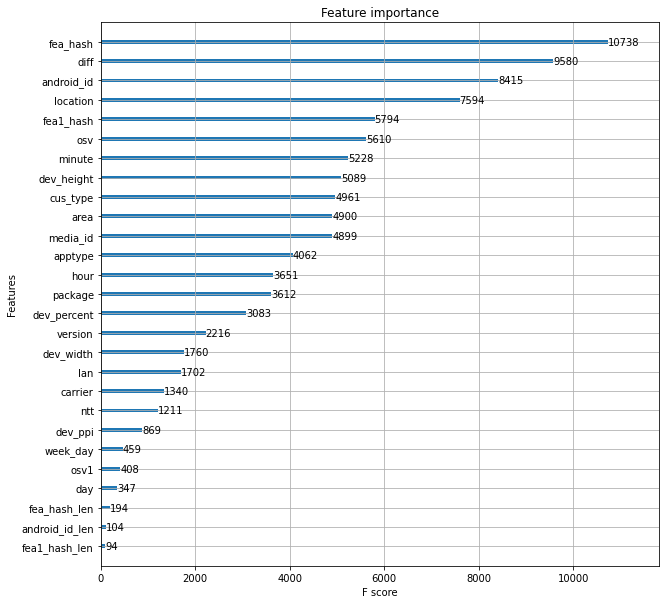

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 10))
plot_importance(model_xgb, ax)
pyplot.show()

In [ ]:
test_pred = model_xgb.predict(test_features.drop(['timestamp'],axis=1))
test_pred

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
#特征重要性贡献中，year,month不在其中
test_features.columns

Index(['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi',
       'dev_width', 'lan', 'media_id', 'ntt', 'osv', 'package', 'timestamp',
       'version', 'fea_hash', 'location', 'fea1_hash', 'cus_type',
       'fea_hash_len', 'fea1_hash_len', 'android_id_len', 'osv1', 'year',
       'month', 'day', 'week_day', 'hour', 'minute', 'diff', 'area',
       'dev_percent'],
      dtype='object')

In [ ]:
test_pred1 = model_xgb.predict_proba(test_features.drop(['timestamp'],axis=1))
test_pred1

array([[0.95767725, 0.04232275],
       [0.21463335, 0.78536665],
       [0.9773051 , 0.02269491],
       ...,
       [0.08311164, 0.91688836],
       [0.05884761, 0.9411524 ],
       [0.03460008, 0.9653999 ]], dtype=float32)

In [ ]:
res = pd.DataFrame(test['sid'])
res['label1'] = test_pred1[:,0]
res['label2'] = test_pred1[:,1]
res.to_csv('newxgb.csv', index=False)
res

,sid,label1,label2
0,1440682,0.957677,0.042323
1,1606824,0.214633,0.785367
2,1774642,0.977305,0.022695
3,1742535,0.947905,0.052095
4,1689686,0.050750,0.949250
...,...,...,...
149995,1165373,0.057561,0.942439
149996,1444115,0.024454,0.975546
149997,1134378,0.083112,0.916888
149998,1700238,0.058848,0.941152


In [ ]:
test_pred.shape

(150000, 2)

In [ ]:
result.shape

(150000, 2)

In [ ]:
avg = (result + test_pred)/2
avg

array([[0.86710934, 0.13289066],
       [0.41480902, 0.58519098],
       [0.97358659, 0.02641342],
       ...,
       [0.09181468, 0.90818532],
       [0.05059849, 0.94940151],
       [0.04994033, 0.95005967]])

In [ ]:
avg[:,0]

array([0.86710934, 0.41480902, 0.97358659, ..., 0.09181468, 0.05059849,
       0.04994033])

In [ ]:
res = pd.DataFrame(test['sid'])
res['label'] = avg[:,0]
res['label'] = res['label'].map(lambda x: 0 if x>0.5 else 1)
res.to_csv('baseline4_xgb+lgb.csv', index=False)
res

,sid,label
0,1440682,0
1,1606824,1
2,1774642,0
3,1742535,0
4,1689686,1
...,...,...
149995,1165373,1
149996,1444115,1
149997,1134378,1
149998,1700238,1
